In [25]:
# 1. IMPORTAZIONE LIBRERIE

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

sns.set(style="whitegrid", font_scale=1.0)

In [ ]:
# 2. CARICAMENTO DATASET DIRETTAMENTE DA UCI

data_raw = fetch_ucirepo(id=967)
data_X = data_raw.data.features
data_y = data_raw.data.targets

data = pd.concat([data_X, data_y], axis=1)

q999 = data["URLLength"].quantile(0.999)
data = data[data["URLLength"] <= q999]

print("Shape:", data.shape)
print("\nPrime righe:\n", data.head())
print("\nColonne:\n", data.columns.tolist())

Shape: (235565, 55)

Prime righe:
                                   URL  URLLength                      Domain  \
0    https://www.southbankmosaics.com         31    www.southbankmosaics.com   
1            https://www.uni-mainz.de         23            www.uni-mainz.de   
2      https://www.voicefmradio.co.uk         29      www.voicefmradio.co.uk   
3         https://www.sfnmjournal.com         26         www.sfnmjournal.com   
4  https://www.rewildingargentina.org         33  www.rewildingargentina.org   

   DomainLength  IsDomainIP  TLD  URLSimilarityIndex  CharContinuationRate  \
0            24           0  com               100.0              1.000000   
1            16           0   de               100.0              0.666667   
2            22           0   uk               100.0              0.866667   
3            19           0  com               100.0              1.000000   
4            26           0  org               100.0              1.000000   

   TLDLegitimat

In [27]:
# 3. DEFINIZIONE TARGET

TARGET = "label"
y = data[TARGET].astype(int).values

In [28]:
# 4. CREAZIONE DI FEATURES

df = data.copy()

# Calcolo della lunghezza del dominio
df["DomainLength"] = df["Domain"].apply(lambda x: len(str(x)))
# Calcolo del numero di punti nell'url
df["URL_DotCount"] = df["URL"].apply(lambda x: str(x).count("."))
# Calcolo del numero di slash nell'url (profondità di esso)
df["URL_SlashCount"] = df["URL"].apply(lambda x: str(x).count("/"))
# Calcolo del rapporto tra lettere e numeri nell'url
df["LetterDigitRatio"] = df["NoOfLettersInURL"] / (df["NoOfDegitsInURL"] + 1)

In [29]:
# 5. RIMOZIONE COLONNE DI LEAKAGE / TESTO

cols_text = ["URL", "Domain", "Title", "TLD"]

cols_leak = [
    "URLSimilarityIndex",
    "DomainTitleMatchScore",
    "URLTitleMatchScore",
    "HasPasswordField",
    "HasExternalFormSubmit",
    "HasSubmitButton",
    "HasHiddenFields",
    "HasDescription",
    "HasSocialNet",
    "HasCopyrightInfo",
    "LineOfCode",
    "LargestLineLength",
    "NoOfImage",
    "NoOfCSS",
    "NoOfJS",
    "NoOfSelfRef",
    "NoOfEmptyRef",
    "NoOfExternalRef",
]

to_drop = [TARGET] + cols_text + [c for c in cols_leak if c in df.columns]
X = df.drop(columns=to_drop)

print("\nColonne rimosse:", to_drop)
print("\nShape finale X:", X.shape)


Colonne rimosse: ['label', 'URL', 'Domain', 'Title', 'TLD', 'URLSimilarityIndex', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasPasswordField', 'HasExternalFormSubmit', 'HasSubmitButton', 'HasHiddenFields', 'HasDescription', 'HasSocialNet', 'HasCopyrightInfo', 'LineOfCode', 'LargestLineLength', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']

Shape finale X: (235565, 35)


In [30]:
# 6. SPLIT IN TRAIN, VALIDATION E TEST SETS

# 20% diventa di test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Dell'80% rimanente si effettua una divisione 75-25 per ottenere il 60% di training e il 20% di validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)

print("\nTrain Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", X_test.shape)


Train Set: (141339, 35)
Validation Set: (47113, 35)
Test Set: (47113, 35)


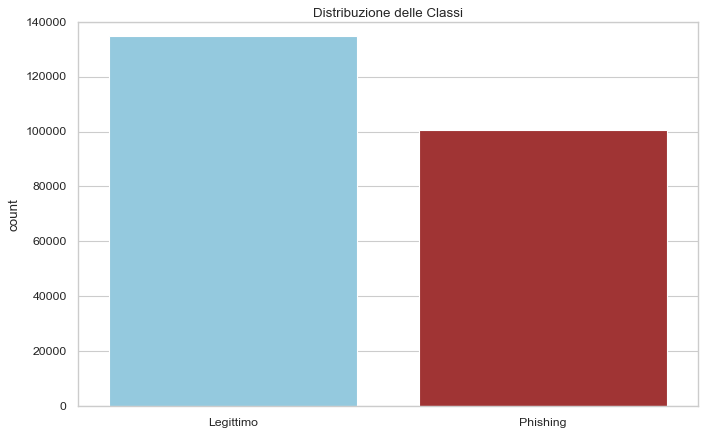

In [31]:
# 7. VISUALIZZAZIONE DISTRIBUZIONE DELLE CLASSI CON GRAFICO A BARRE

y_str = y.astype(str)
plt.figure(figsize=(10, 6))

sns.countplot(
    x=y_str,
    hue=y_str,
    legend=False,
    order=["1", "0"],
    palette={"1": "skyblue", "0": "firebrick"},
)

plt.title("Distribuzione delle Classi")
plt.xticks(ticks=[0, 1], labels=["Legittimo", "Phishing"])

plt.show()

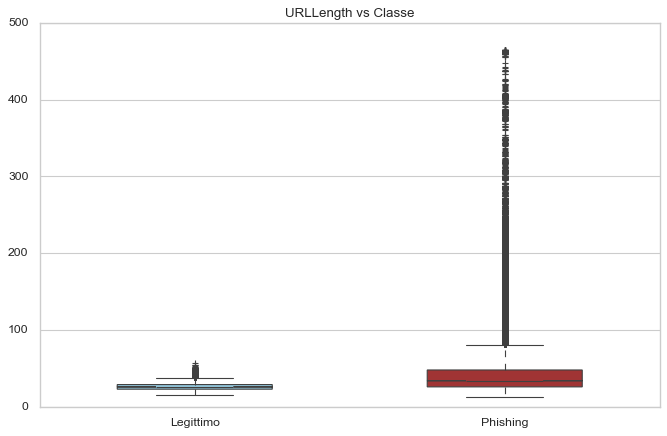

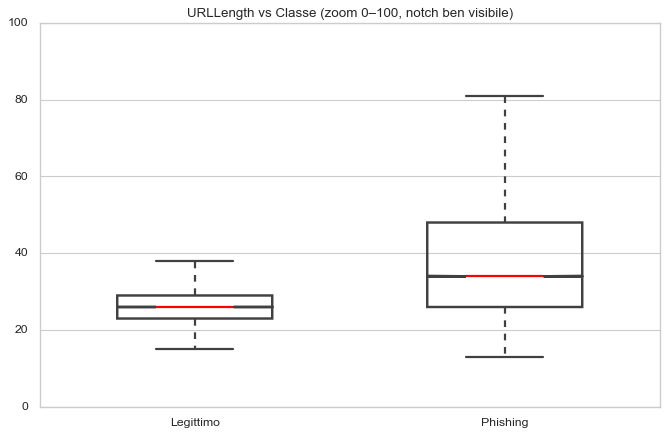

In [32]:
# 8. VISUALIZZAZIONE URLLENGTH VS CLASSE CON BOX PLOTS

if "URLLength" in X.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x=y_str,
        y=X["URLLength"],
        hue=y_str,
        legend=False,
        palette={"1": "skyblue", "0": "firebrick"},
        notch=True,
        width=0.5,
    )

    plt.ylabel("")
    plt.xticks(ticks=[0, 1], labels=["Legittimo", "Phishing"]) 
    plt.title("URLLength vs Classe")
    plt.show()

    plt.figure(figsize=(10, 6))

    sns.boxplot(
        x=y_str,
        y=X["URLLength"],
        hue=y_str,
        legend=False,
        notch=True,
        showfliers=False,
        linewidth=2.2,
        width=0.5,
        boxprops={"facecolor": "none"},
        medianprops={"color": "red", "linewidth": 2},
        whiskerprops={"linewidth": 2},
        capprops={"linewidth": 2},
        palette={"1": "skyblue", "0": "firebrick"},
    )
    
plt.ylabel("")
plt.xticks(ticks=[0, 1], labels=["Legittimo", "Phishing"])
plt.ylim(0, 100)
plt.title("URLLength vs Classe (zoom 0–100, notch ben visibile)")
plt.show()

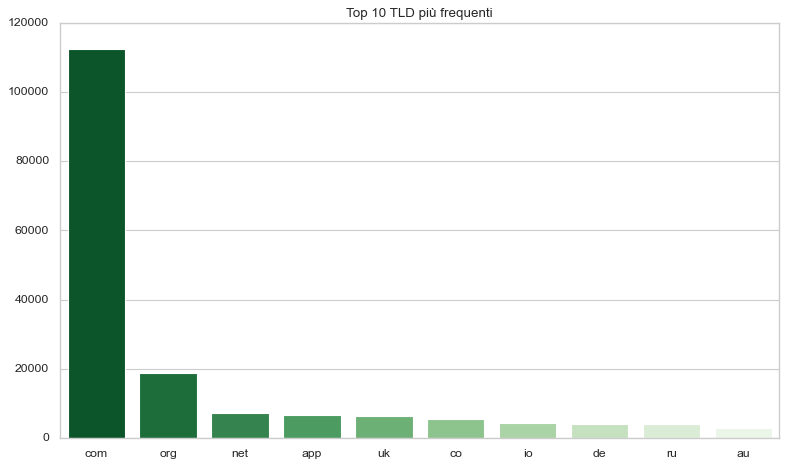

In [75]:
# 9. VISUALIZZAZIONE TOP 10 TLD CON GRAFICO A BARRE

tld_counts = data["TLD"].astype(str).value_counts().head(10)

colors = sns.color_palette("Greens", n_colors=len(tld_counts))
colors = colors[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(
    x=tld_counts.index,
    y=tld_counts.values,
    palette=colors,
    hue=tld_counts.index,
    legend=False
)

plt.title("Top 10 TLD più frequenti")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# 10. OUTPUT TESTUALE DELLA DISTRIBUZIONE DEI TLD PER CLASSE (ORDINE PER NUMERO DI PHISHING EFFETTIVI)

data["TLD"] = data["TLD"].astype(str)

tld_table = pd.crosstab(data["TLD"], data["label"])
tld_table.columns = ["Phishing (0)", "Legittimo (1)"]

tld_table = tld_table[["Phishing (0)", "Legittimo (1)"]]

tld_table["Totale"] = tld_table["Phishing (0)"] + tld_table["Legittimo (1)"]

tld_table["% Phishing"] = (tld_table["Phishing (0)"] /
                           tld_table["Totale"] * 100).round(2)

tld_table_sorted = tld_table.sort_values(
    by=["Phishing (0)", "Legittimo (1)"],
    ascending=False
)

print("\n=== Distribuzione TLD per classe ===")
print(tld_table_sorted.head(20))


=== Distribuzione TLD per classe ===
      Phishing (0)  Legittimo (1)  Totale  % Phishing
TLD                                                  
com          43662          68785  112447       38.83
app           6366            140    6506       97.85
co            4964            458    5422       91.55
io            3765            432    4197       89.71
net           3086           3998    7084       43.56
ru            2982            892    3874       76.97
top           2327              2    2329       99.91
dev           2310             33    2343       98.59
org           2268          16524   18792       12.07
site          1477              5    1482       99.66
link          1455              8    1463       99.45
xyz           1446             25    1471       98.30
cf            1203              0    1203      100.00
ga            1107              4    1111       99.64
ml             994              1     995       99.90
info           893            673    1566   

<Figure size 800x480 with 0 Axes>

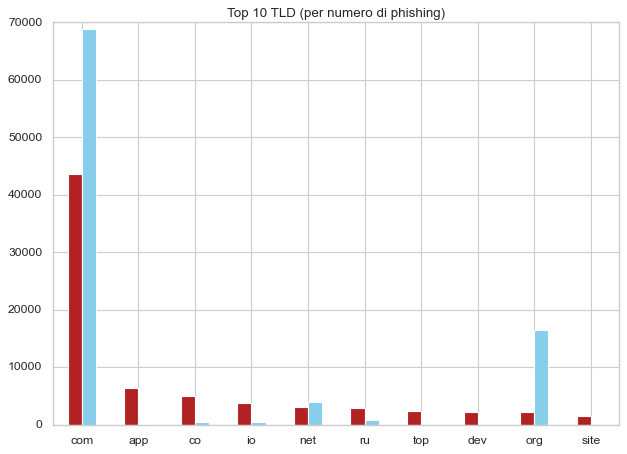

In [ ]:
# 11. VISUALIZZAZIONE DELLA TOP 10 TLD PER NUMERO DI PHISHING E CONFRONTO CON RELATIVI LEGITTIMI CON GRAFICO A BARRE

top10_tld = tld_table_sorted.head(10)

plt.figure(figsize=(10, 6))
top10_tld[["Phishing (0)", "Legittimo (1)"]].plot(kind="bar", stacked=False,
                                                  color=["firebrick", "skyblue"])

plt.title("Top 10 TLD (per numero di phishing)")
plt.xlabel("")
plt.ylabel("")
plt.legend().remove()
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()


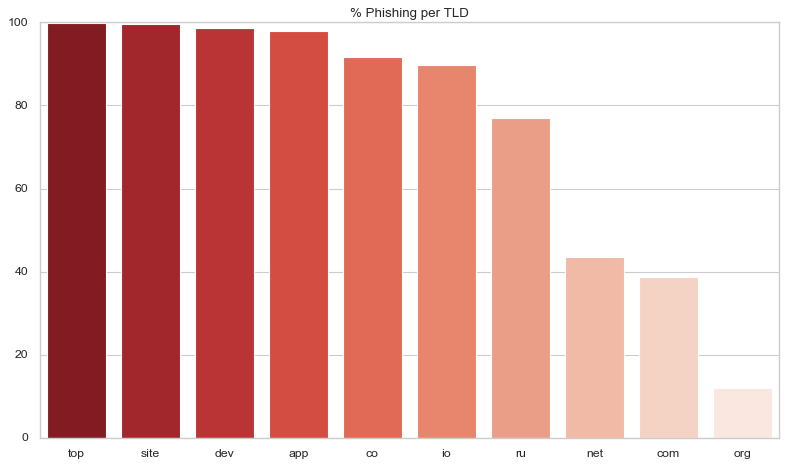

In [97]:
# 12. VISUALIZZAZIONE DELLA PERCENTUALE DI PHISHING PER TLD CON GRAFICO A BARRE

plt.figure(figsize=(10, 6))

top10_sorted_by_pct = top10_tld.sort_values("% Phishing", ascending=False)

colors = sns.color_palette("Reds", n_colors=len(top10_sorted_by_pct))
colors_reversed = list(reversed(colors))

sns.barplot(
    x=top10_sorted_by_pct.index,
    y=top10_sorted_by_pct["% Phishing"],
    palette=colors_reversed,
    hue=top10_sorted_by_pct.index,
    legend=False
)

plt.title("% Phishing per TLD")
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

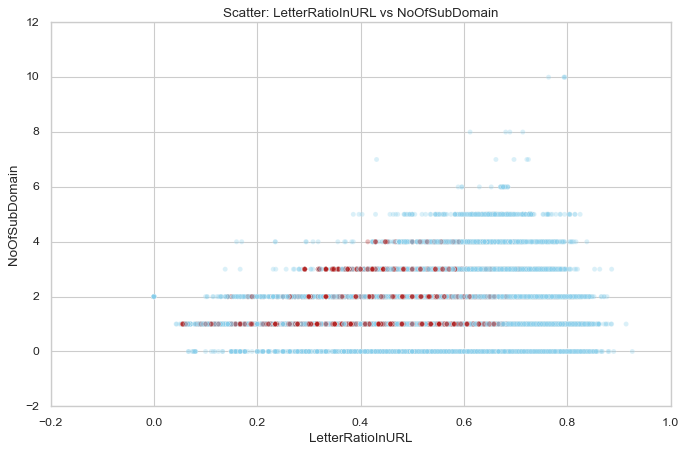

In [46]:
# 13. LETTERRATIOINURL VS NOOFSUBDOMAIN CON SCATTERPLOT

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=X["LetterRatioInURL"],
    y=X["NoOfSubDomain"],
    hue=y_str,
    alpha=0.3,
    palette={"1": "firebrick", "0": "skyblue"},
    legend=False
)

plt.title("Scatter: LetterRatioInURL vs NoOfSubDomain")
plt.xlabel("LetterRatioInURL")
plt.ylabel("NoOfSubDomain")
plt.show()

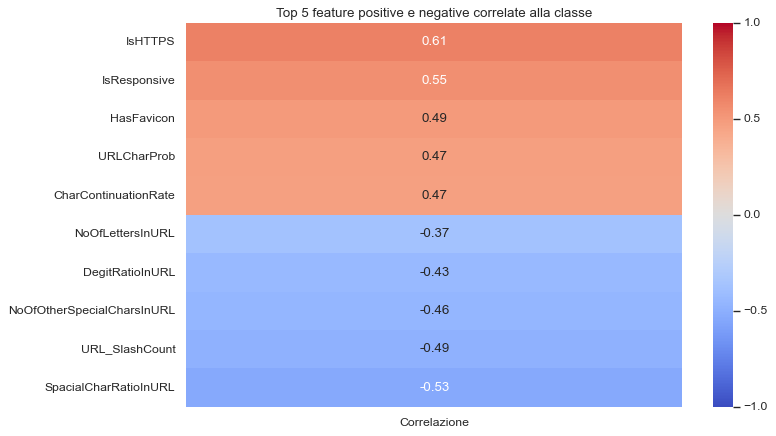

In [38]:
 
# 14. CALCOLO DELLE 5 FEATURE PIU' CORRELATE POSITIVAMENTE E NEGATIVAMENTE CON LA VARIABILE TARGET

df_corr = X.copy()
df_corr[TARGET] = y
corr = df_corr.corr()[TARGET].drop(TARGET).sort_values()

bottom5 = corr.head(5)
top5 = corr.tail(5)

balanced = pd.concat([bottom5, top5])
balanced = balanced.sort_values(ascending=True)
balanced = balanced[::-1]

plt.figure(figsize=(10, 6))
sns.heatmap(
    balanced.to_frame("Correlazione"), annot=True, cmap="coolwarm", vmin=-1, vmax=1
)
plt.title("Top 5 feature positive e negative correlate alla classe")
plt.show()

In [39]:
# 15. METODO PER SCEGLIERE GLI IPERPARAMETRI MIGLIORI PER UN CART, RIPETENDO LA RICERCA CON DIVERSI SEED

param_grid = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 20, 50],
    "min_samples_leaf": [1, 5, 10],
}

best_params_all = []

for seed in [0, 1, 2, 3, 4]:
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=seed),
        param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
    )
    grid.fit(X_train, y_train)
    best_params_all.append(tuple(grid.best_params_.items()))

from collections import Counter

best_params_mode = Counter(best_params_all).most_common(1)[0][0]
best_params_dict = dict(best_params_mode)

print("\nMigliori iperparametri trovati:", best_params_dict)

cart = DecisionTreeClassifier(random_state=42, **best_params_dict)
cart.fit(X_train, y_train)


Migliori iperparametri trovati: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [40]:
# 16. CALCOLO DELL'ACCURATEZZA DEL MODELLO SU VALIDATION E TEST SET

y_pred_val = cart.predict(X_val)
y_pred_test = cart.predict(X_test)

print("\nAccuracy (Validation Set):", accuracy_score(y_val, y_pred_val))
print("Accuracy (Test Set):", accuracy_score(y_test, y_pred_test))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))


Accuracy (Validation Set): 0.9982382781822426
Accuracy (Test Set): 0.9979411202852716

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20143
           1       1.00      1.00      1.00     26970

    accuracy                           1.00     47113
   macro avg       1.00      1.00      1.00     47113
weighted avg       1.00      1.00      1.00     47113



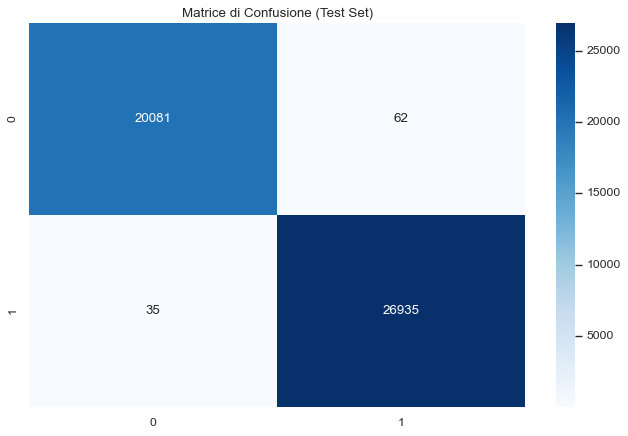

In [41]:
# 17. CREAZIONE DELLA MATRICE DI CONFUSIONE UTILIZZANDO IL TEST SET

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione (Test Set)")
plt.show()

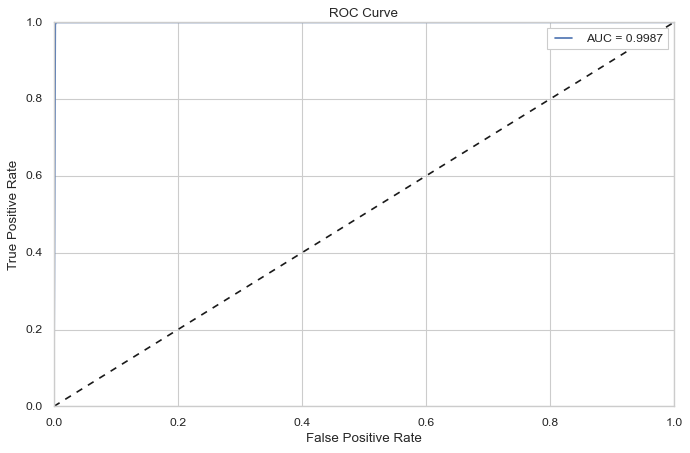

In [42]:
# 18. CALCOLO DELLA CURVA ROC E DEL VALORE AUC

y_score = cart.predict_proba(X_test)[:, 1]
fpr, tpr, th = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

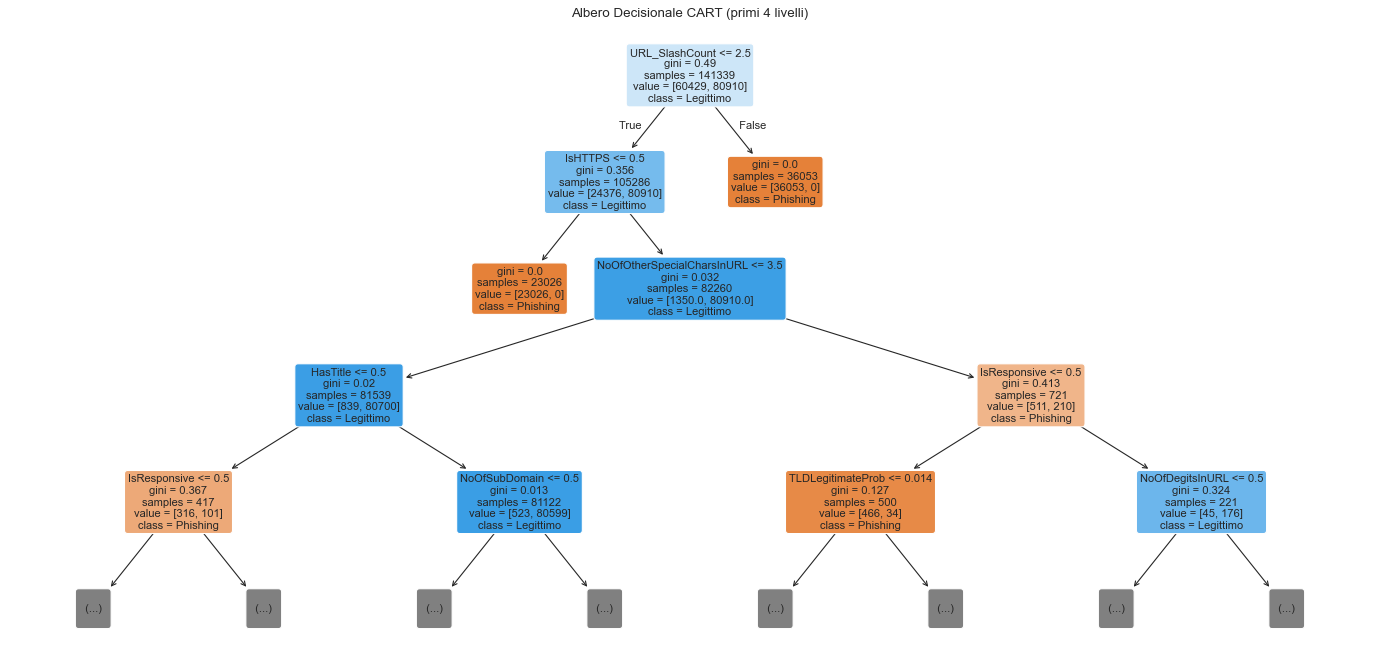

In [107]:
# 19. VISUALIZZAZIONE DEI PRIMI 4 LIVELLI DELL'ALBERO CART

plt.figure(figsize=(22, 10))
plot_tree(
    cart,
    feature_names=X.columns,
    class_names=["Phishing", "Legittimo"],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=4,
)
plt.title("Albero Decisionale CART (primi 4 livelli)")
plt.show()

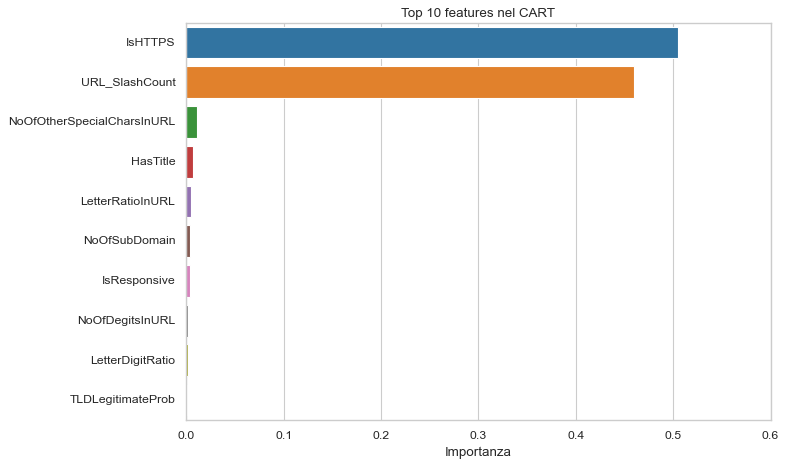


Top 10 features nel CART:
                       Feature  Importanza
20                     IsHTTPS    0.504723
33              URL_SlashCount    0.459941
18  NoOfOtherSpecialCharsInURL    0.010737
21                    HasTitle    0.006792
12            LetterRatioInURL    0.004361
7                NoOfSubDomain    0.003980
24                IsResponsive    0.003749
13             NoOfDegitsInURL    0.001714
34            LetterDigitRatio    0.001176
4            TLDLegitimateProb    0.000610


In [44]:
# 20. FEATURE IMPORTANCE DELL'ALBERO CART CON GRAFICO A BARRE E OUTPUT RELATIVO TESTUALE

imp = pd.DataFrame(
    {"Feature": X.columns, "Importanza": cart.feature_importances_}
).sort_values(by="Importanza", ascending=False)

top10 = imp.head(10)

colors = sns.color_palette("tab10", n_colors=10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x="Importanza",
    y="Feature",
    palette=colors,
    hue="Feature",
    legend=False
)

plt.title("Top 10 features nel CART")
plt.xlabel("Importanza")
plt.ylabel("")
plt.tight_layout()
plt.show()

print("\nTop 10 features nel CART:")
print(top10)

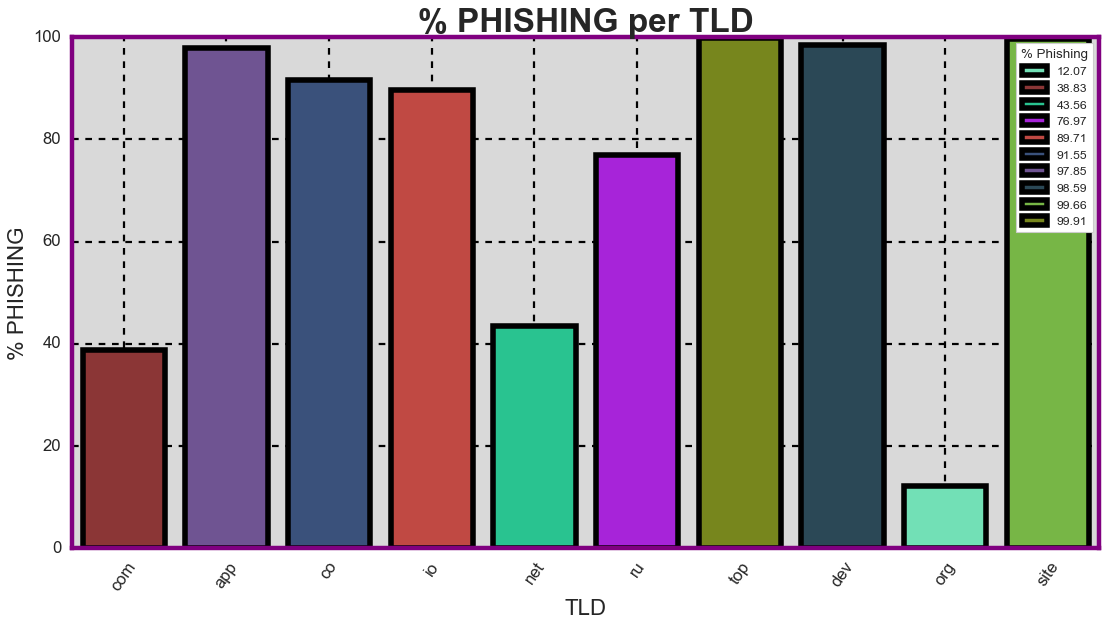

In [95]:
plt.figure(figsize=(14, 8))

ugly_df = top10_tld

import numpy as np
np.random.seed(42)
random_colors = [tuple(np.random.rand(3)) for _ in range(len(ugly_df))]

sns.barplot(
    x=ugly_df.index,
    y=ugly_df["% Phishing"],
    palette=random_colors,
    edgecolor="black",
    linewidth=5,
    hue=ugly_df["% Phishing"]
)

plt.grid(True, which='both', axis='both', color="black", linestyle="--", linewidth=2)

plt.title("% PHISHING per TLD", fontsize=30, fontweight="bold")

plt.xlabel("TLD", fontsize=20)
plt.ylabel("% PHISHING", fontsize=20)
plt.gca().set_facecolor("#D9D9D9") 

plt.xticks(rotation=55, fontsize=15)
plt.yticks(fontsize=15)

for spine in plt.gca().spines.values():
    spine.set_linewidth(4)
    spine.set_color("purple")


plt.tight_layout()
plt.show()